In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import random
import numpy as np
from tqdm.notebook import tqdm
from tabulate import tabulate
from omnibelt import load_json, save_json, load_yaml, save_yaml
from pathlib import Path
from collections import Counter
import requests
import json
import clipboard
# from googlefinance import getQuotes
from bs4 import BeautifulSoup
# import requests, sys, lxml.html

from yahooquery import Ticker

from src import *

In [2]:
strt = 'minimal'
# strt = 'balanced'
# strt = 'wreckless'
# strt = 'conservative'

In [3]:
STRATEGIES = load_yaml('config/strategies.yaml')
STRATEGIES.keys()

dict_keys(['balanced', 'conservative', 'wreckless', 'minimal'])

In [4]:
names = []
ratios = STRATEGIES[strt].copy()
ratios = {k:v/100 for k,v in ratios.items()}

names = list(k for k,v in ratios.items() if v > 0)

cats = TYPES.copy()
# cats = {}
# for n in names:
#     t = get_type(n)
#     if t not in cats:
#         cats[t] = []
#     cats[t].append(n)

name = random.choice(names)
name

'ICLN'

In [5]:
sum(ratios.values())

1.0000000000000002

In [6]:
root = Path('figures') / strt
root.mkdir(exist_ok=True)

In [7]:
cat = 'ETF'
# cat = 'EQUITY'
group = 'snapshot'
group = 'holdings'

In [8]:
etfs = load('ETF', 'holdings', pbar=tqdm)
pies = load('ETF', 'composition', pbar=tqdm)
etf_info = load('ETF', 'snapshot', pbar=tqdm)
stocks_info = load('EQUITY', 'snapshot', pbar=tqdm)
features = {'Sector': ('company', 'sector'), 
            'Industry': ('company', 'industry'), 
            'Country':('company', 'country'), 
            'Ticker': ('company', 'ticker'),
            
    'score':('analyst', 'score'),
    'employees':('company', 'employees'),
    'cap': ('compare', 1, 1),
    'perf': ('compare', 2, 1),
    'eps': ('compare', 4, 1),
    'beta': ('compare', 3, 1),
    'p/e': ('compare', 7, 1),
    'yield': ('compare', 8, 1),
}

etf_feats = {
    'p/e': ('stats', 'Price / Earnings (Trailing Twelve Months)'),
    'assets': ('info', 'Net Assets'),
    'expense': ('info', 'Net Expense Ratio'),
    'yield': ('stats', 'Distribution Yield (TTM)'),
    'beta': ('compare', 5, 1),
    'ratings': ('analyst'),
    'perf': ('compare', 3, 1),
}

etf_stats = collect(etf_info, etf_feats)
stocks = collect(stocks_info, features)
for tk, info in stocks.items():
    if info['yield'] is not None:
        info['yield'] = float(info['yield'][:-1])
len(etfs), len(pies), len(stocks), len(etf_info)

(41, 41, 27, 41)

In [9]:
for ticker, hlds in etfs.items():
    den = sum(row[-1] for row in hlds)
    for row in hlds:
        row[-1] /= den

for ticker, ps in pies.items():
    for key in ['Holdings', 'Sector Exposure', 'Industry Exposure', 'Country Exposure', 
                'Maturity', 'Credit Grade', 'Debt Type', ]:
        if key in ps:
            den = sum(ps[key].values())
            for k,v in ps[key].items():
                ps[key][k] = v / den

nosize = []
for tk, info in stocks.items():
    if info['cap'] is not None:
        for c, lim in MARKET_CAPS:
            if info['cap'] > lim:
                info['size'] = c
                break
        if 'size' not in info:
            info['size'] = None
    else:
        nosize.append(tk)
nosize

['TCEHY']

In [10]:

companies = {}
countries = {}
sectors = {}
industry = {}
maturity = {}
grades = {}
caps = {}

tbls = { 'countries':countries, 'sectors':sectors, #'companies':companies,
        'industry':industry, 'maturity':maturity, 'grades':grades, 'caps':caps}

for ticker, ratio in ratios.items():
#     if ratio > 0:
#         if ticker in etfs:
#             info = etfs[ticker]
            
#             for tk, _, land, q in info:
#                 if tk not in companies:
#                     companies[tk] = 0.
#                 companies[tk] += q * ratio
#                 if land not in countries:
#                     countries[land] = 0.
#                 countries[land] += q * ratio
        
    if ticker in pies and 'Market Capitalization' in pies[ticker]:
        for size, q in pies[ticker]['Market Capitalization'].items():
            size = size.lower()
            if size not in caps:
                caps[size] = 0.
            caps[size] += q*ratio / 100
    
    if ticker in stocks:
        info = stocks[ticker]

        if 'size' in info and info['size'] is not None:
            size = info['size']
            if size not in caps:
                caps[size] = 0.
            caps[size] += ratio
        
#         if ticker not in companies:
#             companies[ticker] = 0.
#         companies[ticker] += ratio

        land = info['Country']
        if land not in countries:
            countries[land] = 0.
        countries[land] += ratio

        sec = info['Sector']
        if sec not in sectors:
            sectors[sec] = 0.
        sectors[sec] += ratio

        ind = info['Industry']
        if ind not in industry:
            industry[ind] = 0.
        industry[ind] += ratio

#         else:
#             assert False, f'{ticker}'

    if ticker in pies:
        info = pies[ticker]

        if info['Asset Classification'] == 'Equity':

            if 'Sector Exposure' not in info:
                print(f'{ticker} sector failed')
            else:
                for sec, q in info['Sector Exposure'].items():
                    if sec not in sectors:
                        sectors[sec] = 0.
                    sectors[sec] += q * ratio

            if 'Industry Exposure' not in info:
                print(f'{ticker} industry failed')
            else:
                for ind, q in info['Industry Exposure'].items():
                    if ind not in industry:
                        industry[ind] = 0.
                    industry[ind] += q * ratio

        elif info['Asset Classification'] == 'Fixed Income':

            if 'Bonds' not in sectors:
                sectors['Bonds'] = 0.
            sectors['Bonds'] += ratio

            for t, q in info['Debt Type'].items():
                if t not in industry:
                    industry[t] = 0.
                industry[t] += ratio * q

            for g, q in info['Credit Grade'].items():
                if g not in grades:
                    grades[g] = 0.
                grades[g] += q * ratio

            for m, q in info['Maturity'].items():
                if m not in maturity:
                    maturity[m] = 0
                maturity[m] += q * ratio

        elif info['Asset Classification'] == 'Commodity':
            for mat, q in info['Holdings'].items():
                if mat not in industry:
                    industry[mat] = 0.
                industry[mat] += ratio * q

            if 'Commodity' not in sectors:
                sectors['Commodity'] = 0.
            sectors['Commodity'] += ratio
        else:
            if 'Unknown' not in sectors:
                sectors['Unknown'] = 0.
            sectors['Unknown'] += ratio
#             if 'Unknown' not in countries:
#                 countries['Unknown'] = 0
#             countries['Unknown'] += ratio
#             if 'Unknown' not in companies:
#                 companies['Unknown'] = 0
#             companies['Unknown'] += ratio
            if 'Unknown' not in industry:
                industry['Unknown'] = 0
            industry['Unknown'] += ratio
#                 raise Exception(ticker)

#             if info['Asset Classification'] != 'Commodity':
    if ticker in etfs:
        holdings = etfs[ticker]
        for tk, _, land, q in holdings:
#             if tk not in companies:
#                 companies[tk] = 0.
#             companies[tk] += q * ratio
            if land not in countries:
                countries[land] = 0.
            countries[land] += q * ratio

regions = {}
for land, q in countries.items():
    key = REGIONS.get(land, 'Unknown')
    if key not in regions:
        regions[key] = 0.
    regions[key] += q
tbls['regions'] = regions    
        
    
for tbl in tbls.values():
    if None in tbl:
        if 'Unknown' not in tbl:
            tbl['Unknown'] = 0.
        tbl['Unknown'] += tbl[None]
        del tbl[None]
    
sum(countries.values()), sum(companies.values()), sum(sectors.values()), sum(industry.values())

(0.999999999999994, 0, 1.0, 1.0)

In [11]:
remove_keys(countries, {'Xav Health Care Mar21 Xcme 20210319', 'Xai Emini Industr Mar21 Xcme 20210319', 'XAF FINANCIAL MAR21 XCME 20210319'})

In [12]:
tbls.keys()

dict_keys(['countries', 'sectors', 'industry', 'maturity', 'grades', 'caps', 'regions'])

In [13]:
stocks['TSLA']

{'Sector': 'Consumer Discretionary',
 'Industry': 'Automobiles',
 'Country': 'United States',
 'Ticker': 'TSLA',
 'score': 8.6,
 'employees': 48016,
 'cap': 834170000000.0,
 'perf': 814.14,
 'eps': 0.51,
 'beta': 1.87,
 'p/e': '1,767.11',
 'yield': None,
 'size': 'mega'}

In [14]:
etf_stats['SPY']

{'p/e': 28.32,
 'assets': 329000000000.0,
 'expense': 0.09,
 'yield': 1.52,
 'beta': 1.0,
 'FactSet': 5,
 'Morningstar, Inc.': 4,
 'perf': 18.37}

In [15]:
performance = 0.
perf_f = 0.
yld = 0.
yld_f = 0.
expense = 0.
score = 0.
score_factor = 0.
av_pe = 0.
av_pe_f = 0.
pe = {}

for tk, info in etf_stats.items():
    if tk in ratios:
        r = ratios[tk]
        if 'p/e' in info:
            if isinstance(info['p/e'], str):
                if ',' in info['p/e']:
                    info['p/e'] = float(info['p/e'].replace(',', ''))
                else:
                    info['p/e'] = None
            pe[tk] = info['p/e']
            if pe[tk] is not None:
                av_pe += r * pe[tk]
                av_pe_f += r
        if 'perf' in info and isinstance(info['perf'], (float,int)):
            performance += r * info['perf']
            perf_f += r
        if 'yield' in info and isinstance(info['yield'], (float,int)):
            yld += r * info['yield'] / 100
            yld_f += r
        if isinstance(info['expense'], (float,int)):
            expense += r * info['expense']
        if 'Morningstar, Inc.' in info and isinstance(info['Morningstar, Inc.'], (float,int)) \
        and 'FactSet' in info and isinstance(info['FactSet'], (float,int)):
            score += r * (info['Morningstar, Inc.'] + info['FactSet'])
            score_factor += r
for tk, info in stocks.items():
    if tk in ratios:
        r = ratios[tk]
        if 'p/e' in info:
            if isinstance(info['p/e'], str):
                if ',' in info['p/e']:
                    info['p/e'] = float(info['p/e'].replace(',', ''))
                else:
                    info['p/e'] = None
            pe[tk] = info['p/e']
            if pe[tk] is not None:
                av_pe += r * pe[tk]
                av_pe_f += r
        if 'perf' in info and isinstance(info['perf'], (float,int)):
            performance += r * info['perf']
            perf_f += r
        if 'yield' in info and isinstance(info['yield'], (float,int)):
            yld += r * info['yield'] / 100
            yld_f += r
        if 'expense' in info and isinstance(info['expense'], (float,int)):
            expense += r * info['expense']
        if 'score' in info and isinstance(info['score'], (float,int)):
            score += r * info['score']
            score_factor += r
        
len(ratios), expense, performance, perf_f, yld, yld_f, score, score_factor, av_pe, av_pe_f

(15,
 0.3153,
 52.21490000000001,
 1.0000000000000002,
 0.010684,
 1.0000000000000002,
 7.450000000000001,
 0.9500000000000001,
 21.172500000000003,
 0.75)

In [16]:
key = 'P/E'
top = get_top(pe, None, factor=1)
print(tabulate(top, headers=['Ticker', 'P/E']))

Ticker      P/E
--------  -----
ICLN      36.98
KWEB      36.98
VONG      35.71
SPY       28.32
VTI       27
VXF       25.58
SPDW      20.85
EMXC      20.22
ASHR      19.11
XITK
ICVT
LQD
SCHP
ARKK
IAU


In [17]:
len(ratios)

15

In [18]:
key = 'maturity'
top = get_top(tbls[key], None)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Maturity             Amount (%)
-----------------  ------------
Intermediate Term       1.49565
Long Term               1.27253
Short Term              1.23182


In [19]:
key = 'grades'
top = get_top(tbls[key], None)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Grades              Amount (%)
----------------  ------------
AAA                    2.06399
Investment Grade       1.93601
High Yield             0


In [20]:
key = 'regions'

In [21]:
top = get_top(tbls[key], None)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Regions          Amount (%)
-------------  ------------
North America     63.3917
Asia              27.1122
Europe             6.04216
Unknown            1.43228
Latin America      0.947956
Middle East        0.812506
Africa             0.261276


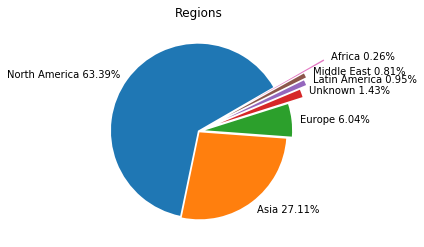

In [22]:
plt.figure()
l,x = list(zip(*top))
l = [f'{L} {X:.2f}%' for L,X in zip(l,x)]
plt.pie(x, labels=l, explode=[1/(2*v+1) for v in x], startangle=30) # 
plt.title(key.capitalize())
plt.savefig(str(root / f'{key}.png'))
pass

In [23]:
key = 'countries'

In [24]:
top = get_top(tbls[key], 15)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Countries         Amount (%)
--------------  ------------
United States      62.3804
China              21.3511
South Korea         1.56283
Unknown             1.43228
Japan               1.33118
Taiwan              1.12739
Switzerland         1.06333
Canada              1.01125
United Kingdom      1.01049
Brazil              0.65793
Spain               0.644734
Denmark             0.54761
France              0.544404
New Zealand         0.4991
Germany             0.491521
Other               4.34449


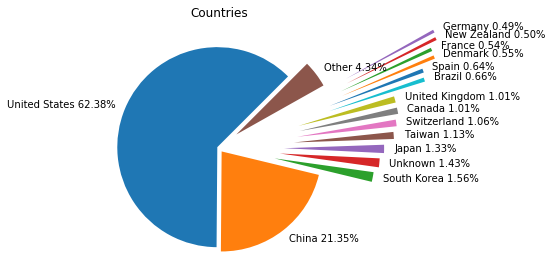

In [25]:
plt.figure()
l,x = list(zip(*top))
l = [f'{L} {X:.2f}%' for L,X in zip(l,x)]
plt.pie(x, labels=l, explode=[1/(v+.2) for v in x], startangle=45) # 
plt.title(key.capitalize())
plt.tight_layout()
plt.savefig(str(root / f'{key}.png'))
pass

In [26]:
key = 'sectors'

In [27]:
top = get_top(tbls[key], None)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Sectors                   Amount (%)
----------------------  ------------
Information Technology      23.7602
Consumer Discretionary      13.9185
Communication Services      11.2023
Health Care                 11.0701
Financials                   8.55214
Industrials                  6.9963
Unknown                      5
Consumer Staples             4.60671
Bonds                        4
Utilities                    3.64189
Materials                    2.59403
Real Estate                  2.39104
Energy                       1.26691
Commodity                    1


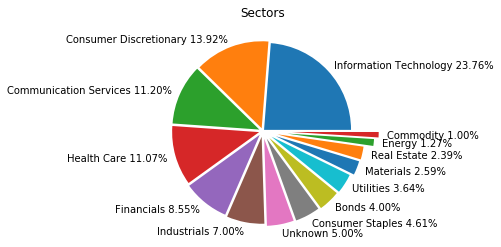

In [28]:
plt.figure()
l,x = list(zip(*top))
l = [f'{L} {X:.2f}%' for L,X in zip(l,x)]
plt.pie(x, labels=l, explode=[1/(2*v+1) for v in x], startangle=0) # 
plt.title(key.capitalize())
plt.savefig(str(root / f'{key}.png'))
pass

In [29]:
key = 'industry'

In [30]:
top = get_top(tbls[key], 49)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Industry                                          Amount (%)
----------------------------------------------  ------------
Software                                            9.38867
Internet & Direct Marketing Retail                  6.36694
Interactive Media & Services                        5.70171
Semiconductors & Semiconductor Equipment            5.07871
Unknown                                             5
Biotechnology                                       4.24948
Entertainment                                       4.0726
IT Services                                         4.01753
Banks                                               3.64868
Technology Hardware, Storage & Peripherals          3.5777
Automobiles                                         2.7304
Pharmaceuticals                                     2.01349
Government                                          2.00286
Corporate                                           1.99714
Beverages                                      

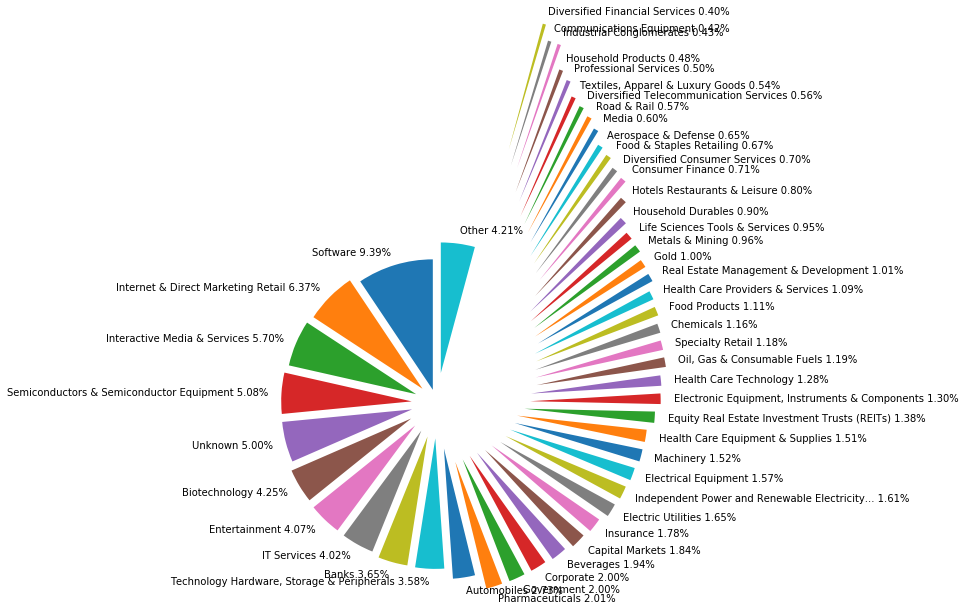

In [31]:
plt.figure(figsize=(6,6))
l,x = list(zip(*top))
l = [f'{L} {X:.2f}%' for L,X in zip(l,x)]
plt.pie(x, labels=l, explode=[1/(v+.1) for v in x], startangle=90)
# plt.title(key.capitalize())
plt.savefig(str(root / f'{key}.png'))
pass

In [32]:
# key = 'companies'

In [33]:
# top = get_top(tbls[key], 50)
# print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

In [34]:
etfs['ASHR']

[['600519', 'Kweichow Moutai Co Ltd', 'China', 0.0495411033257674],
 ['601318',
  'Ping An Insurance (Group) Co. of China Ltd',
  'China',
  0.047271291818809937],
 ['000858', 'Wuliangye Yibin Co Ltd', 'China', 0.028323300108556267],
 ['600036', 'China Merchants Bank Co Ltd', 'China', 0.027040363169841177],
 ['000333', 'Midea Group Co Ltd Class A', 'China', 0.023981052008289806],
 ['600276', 'Jiangsu Hengrui Medicine Co Ltd', 'China', 0.02141517813085962],
 ['601166', 'Industrial Bank Co Ltd', 'China', 0.015493930721405348],
 ['-CASH-', 'Chinese Yuan', None, 0.015099180894108395],
 ['000651',
  'Gree Electric Appliances Inc of Zhuhai',
  'China',
  0.015000493437284155],
 ['600887',
  'Inner Mongolia Yili Industrial Group Co Ltd',
  'China',
  0.013618869041744825],
 ['601888',
  'China Tourism Group Duty Free Corp Ltd Class A',
  'China',
  0.01292805684397516],
 ['600030', 'CITIC Securities Co Ltd', 'China', 0.012335932103029735],
 ['601012',
  'LONGi Green Energy Technology Co Ltd C

In [35]:
currency = {
    'Us Dollar': 'USD',
    'Cash†': 'USD',
    'Cashusd': 'USD',
    'Japanese Yen': 'JPY',
    'Polish Zloty': 'PLN',
    'British Pound Sterling': 'GBP',
    'Norwegian Krone': 'NOK',
    'Chinese Yuan': 'CNY',
    'Pound Sterling': 'GBP',
    'Euro Currency': 'EUR',
    'Canadian Dollar': 'CAD',
    'Swiss Franc': 'CHF',
    'Australian Dollar': 'AUD',
    'Euro': 'EUR',
    'Cash Collateral Eur Ubfut': 'EUR',
    'Hong Kong Dollar': 'HKD',
    'Futures Krw Margin Balance': 'KRW',
    'Cnh Cash': 'CNY',   
}
currency.update({f'{sym.capitalize()} Cash':sym for sym in CURRENCIES})

commodities = {'Gold'}

skippable = {'JFROG LTD COMMON STOCK',
 'State Street Institutional Liq State St Inst Liq Res Prem',
 'Ss Inst Treas Plus Mm Fund Tru Ss Inst Treas Plus Mm Fund Tru',
 'E-Mini Russ 2000 Mar21 Xcme 20210319',
 'Hirogin Holdings Inc Common Stock',
 'Ssc Government Mm Gvmxx',
 'Interest/Overdraft',
 'Ss Inst Treas Plus Mm Fund Tru Ss Inst Treas Plus Mm Fund Tru',
 'E-Mini Russ 2000 Mar21 Xcme 20210319',
 'Engie Loyalty Line 2021',
 'Edf (Electricie De France) Loyalty Line 2021',
 'BANCO SANTANDER SA (RTS NOV 2020)',
 'Seb Sa (Loyalty Line 2021) New',
 'AVEVA GROUP-NIL',
 'Interest/Overdraft',
 'AVIC SHENYANG AIRCRAFT CO -A',
 'SEAZEN HOLDINGS CO LTD-A',
 'SHENNAN CIRCUITS CO LTD-A',
 'BGI GENOMICS CO LTD-A',
 'SHENNAN CIRCUITS CO LTD-A',
 'State Street Institutional Liq State St Inst Liq Res Prem',
 'Siemens Energy Ag Common Stock',
 'Docebo Inc Common Stock Npv',
 'Adp Common Stock Eur3.0',
 'Lundbergs Ab B Shs Common Stock',
 'Befesa Sa Common Stock',
 'Ses Receipt',
 'Money Forward Inc Common Stock',
 'Kadokawa Corp Common Stock',
 'Schaeffler Ag Pref Preference',
 'Ss Inst Treas Plus Mm Fund Tru Ss Inst Treas Plus Mm Fund Tru',
 'E-Mini Russ 2000 Mar21 Xcme 20210319',
 'State Street Institutional Liq State St Inst Liq Res Prem',
 'BlackRock Cash Funds Treasury SL Agency',
 'BlackRock Cash Funds Treasury SL Agency',
 'FirstCash Inc',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Usd Hbcft',
 'FirstCash Inc',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Usd Ubfut',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Msfut Usd',
 'FirstCash Inc',
 'Lancashire Holdings Ltd',
 'Cash Collateral Usd Hbcft',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Usd Sgaft',
 'FirstCash Inc',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Cad Ubfut',
 'BlackRock Cash Funds Treasury SL Agency',
 'BlackRock Cash Funds Treasury SL Agency',
 'BlackRock Cash Funds Treasury SL Agency',
 'Cash Collateral Usd Ubfut',
 'Metcash Ltd',
 'Lancashire Holdings Ltd',
 'Cash Collateral Usd Jpmsw',
 'BlackRock Cash Funds Treasury SL Agency',
 'John Deere Cash Management 0.5%',
 'John Deere Cash Management 2.2%',
 'Lancashire Holdings Ltd',}

aliases = {
    'NTDOY': '7974',
    'TCEHY': '00700',
}


In [36]:
assets = {}
known = set()
skip_it = []
    
for sec, rows in etfs.items():
    if sec in ratios and ratios[sec] > 0:
        r = ratios[sec]
        for row in rows:
            typ = 'Stocks'
            tk, name, land, q = row
            ticker = tk
            if name in commodities:
                typ = 'Commodity'
                ticker = None
                tk = name
                land = None
            if name in currency or tk == '-CASH-':
                if name in currency:
                    tk = currency[name]
                if tk in CURRENCIES:
                    name = CURRENCIES[tk]['name']
                    typ = 'Currency'
                    land = None
                elif name not in skippable:
                    print(sec, name)
                    
            if tk is None and sec == 'ICVT':
                tk = 'Convertible Bonds'
                typ = 'Convertible Bonds'
                name = 'Convertible Bonds'
                ticker = None
                land = None
                
            if tk is None and pies[sec]['Asset Classification'] == 'Fixed Income' or ' Treasury ' in name:
                tk = 'Bonds'
#                 if land is not None:
#                     tk = f'Bonds - {land}'
                typ = 'Bonds'
                name = 'Bonds'
                ticker = None
                land = None
            
            if tk is None:
#                 if name not in skippable:
#                     print(sec, name)
                tk = 'Unknown'
                typ = 'Unknown'
                name = 'Unknown'
                ticker = None
                land = None
            
            if tk not in assets:
                assets[tk] = {'name': name, 'ticker': ticker, 'amount': 0., 'country': land, 'type': typ}
            assets[tk]['amount'] += q * r
            
for tk, info in stocks.items():
    
    if tk in ratios and ratios[tk] > 0:
        r = ratios[tk]
        
        if tk in aliases:
            tk = aliases[tk]
        if tk not in assets:
            print(tk)
        else:
            assets[tk]['employees'] = info['employees']
            assets[tk]['eps'] = info['eps']
            assets[tk]['amount'] += r

# for tk, info in assets.items():
#     if tk != 'Unknown':
#         info['ticker'] = tk
            
skip_it

ARKK Ms Govt Instl Liq Fd 8035


[]

In [37]:
len(assets)

4829

In [38]:
sum(a['amount'] for a in assets.values())

1.000000000000055

In [39]:
assets['Unknown']

{'name': 'Unknown',
 'ticker': None,
 'amount': 0.0033551608243534235,
 'country': None,
 'type': 'Unknown'}

In [40]:
assets['USD']

{'name': 'United States dollar',
 'ticker': '-CASH-',
 'amount': 0.0031160413088704925,
 'country': None,
 'type': 'Currency'}

In [41]:
breakdown = {}
for n, info in assets.items():
    typ = info['type']
    if typ not in breakdown:
        breakdown[typ] = 0.
    breakdown[typ] += info['amount']
breakdown

{'Stocks': 0.8895861210861998,
 'Unknown': 0.0033551608243534235,
 'Currency': 0.007041629250303058,
 'Bonds': 0.04042692490477197,
 'Convertible Bonds': 0.049590163934426224,
 'Commodity': 0.01}

In [42]:
sum(breakdown.values())

1.0000000000000544

In [43]:
# for n, info in assets.items():
#     if info['type'] == 'Currency':
#         print(n, info)

In [44]:
top = get_top(breakdown, None)
print(tabulate(top, headers=['Asset Type', 'Amount (%)']))

Asset Type           Amount (%)
-----------------  ------------
Stocks                88.9586
Convertible Bonds      4.95902
Bonds                  4.04269
Commodity              1
Currency               0.704163
Unknown                0.335516


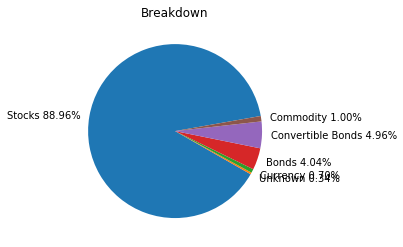

In [45]:
plt.figure()
l,x = breakdown.keys(), breakdown.values()
l = [f'{L} {X*100:.2f}%' for L,X in zip(l,x)]
objs, txt = plt.pie(x, labels=l, startangle=10) # explode=[1/(2*v+1) for v in x], 
# adjust_text(txt)
plt.title('Breakdown')
plt.savefig(str(root / 'breakdown.png'))
pass

In [46]:
full = dicts_to_table(assets, cols=['name', 'ticker', 'country', 'amount'], sort_by='amount', reverse=True, 
                      ignore_key=True, skip_header=True)
for row in full:
    row[-1] *= 100


In [47]:
num = 49
# num = None

if num is None:
    top = full.copy()
else:
    top = full[:num]
    if len(full) > num:
        n = len(top[0])-2
        top.append(['Other'] + [None]*n + [sum(x[-1] for x in full[num:])])
    
csv = []

for line in top:
    row = [('' if x is None else x) for x in line]
#     row[-1] = f'{row[i]/100:.4f}'
    row[-1] = f'{row[-1]:.2f}%'
    csv.append(','.join(row))
    
headers = ['Name', 'Ticker', 'Country', 'Amount']
with (root/'companies.csv').open('w', encoding='utf-8') as f:
    f.write(','.join(headers) + '\n')
    f.write('\n'.join(csv))
    f.write('\n')

In [48]:
print(tabulate(top, headers=headers))

Name                                        Ticker    Country           Amount
------------------------------------------  --------  -------------  ---------
Convertible Bonds                                                     4.95902
Bonds                                                                 4.04269
Apple Inc                                   AAPL      United States   2.27329
Tesla Inc                                   TSLA      United States   2.20598
Microsoft Corp                              MSFT      United States   1.89339
Amazon.com Inc                              AMZN      United States   1.57817
Gold                                                                  1
Tencent Holdings Ltd                        00700     China           0.957056
Facebook Inc A                              FB        United States   0.819573
Meituan                                     03690     China           0.816225
Square Inc A                                SQ        United Stat